In [12]:
%load_ext autoreload
%autoreload 2

import argparse
import os
import time
import scipy.stats as st
import wandb
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import higher

from tqdm import tqdm
from matplotlib import pyplot as plt

import layers
from synthetic_loader import SyntheticLoader
from inner_optimizers import InnerOptBuilder
from train_synthetic import train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
OUTPUT_PATH = "./outputs/synthetic_outputs"

if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
wandb.init(project="weight_sharing_toy", dir=OUTPUT_PATH, mode='online')

In [14]:
class Config:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

cfg = Config(**dict(
    device = 'cpu',
    problem = 'rank1',
    model = 'share_fc',
    k_spt = 1,
    k_qry = 19,
    inner_opt = 'maml',
    outer_opt = 'Adam',
    init_inner_lr = 0.1,
    lr_mode = 'per_layer',
    outer_lr = 0.001,
    num_inner_steps = 1,
    num_outer_steps = 1000,
))

device = torch.device(cfg.device)
db = SyntheticLoader(device, problem=cfg.problem, k_spt=cfg.k_spt, k_qry=cfg.k_qry)


latent = {"rank1": 3, "rank2": 6, "rank5": 30}[cfg.problem]
net = nn.Sequential(layers.ShareLinearFull(70, 68, bias=False, latent_size=latent)).to(device)

inner_opt_builder = InnerOptBuilder(net, device, cfg.inner_opt, cfg.init_inner_lr, "learned", cfg.lr_mode)
meta_opt = optim.Adam(inner_opt_builder.metaparams.values(), lr=cfg.outer_lr)

In [15]:
70*68

4760

In [16]:
for name, l in net.named_parameters():
    print(name, l.size())

0.latent_params torch.Size([3])
0.warp torch.Size([4760, 3])


## Train loop

In [17]:
data, _filters = db.next(32, "train")

In [18]:
x_spt, y_spt, x_qry, y_qry = data
x_spt.shape, y_spt.shape, x_qry.shape, y_qry.shape

(torch.Size([32, 1, 1, 70]),
 torch.Size([32, 1, 1, 68]),
 torch.Size([32, 19, 1, 70]),
 torch.Size([32, 19, 1, 68]))

In [19]:
for step_idx in tqdm(range(cfg.num_outer_steps)):
    data, _filters = db.next(32, "train")
    train(step_idx, data, net, inner_opt_builder, meta_opt, cfg.num_inner_steps)

100%|██████████| 1000/1000 [00:14<00:00, 69.07it/s]


In [20]:
net.eval()

Sequential(
  (0): ShareLinearFull()
)

In [21]:
i = 0
spt_pred = net(x_spt[i])
F.mse_loss(spt_pred, y_spt[i])


tensor(3.0194, grad_fn=<MseLossBackward0>)

In [22]:
qry_pred = net(x_qry[i])
F.mse_loss(qry_pred, y_qry[i])

tensor(3.6468, grad_fn=<MseLossBackward0>)

In [35]:
params = dict(net.named_parameters())
for name, param in params.items():
    print(name, param.shape)

0.latent_params torch.Size([3])
0.warp torch.Size([4760, 3])


In [41]:
U = params['0.warp'].data.reshape(70, 68, 3)
U.shape

torch.Size([70, 68, 3])

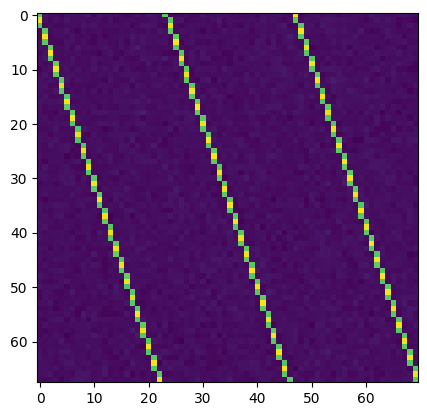

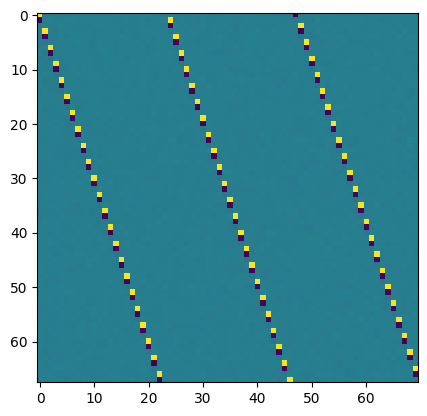

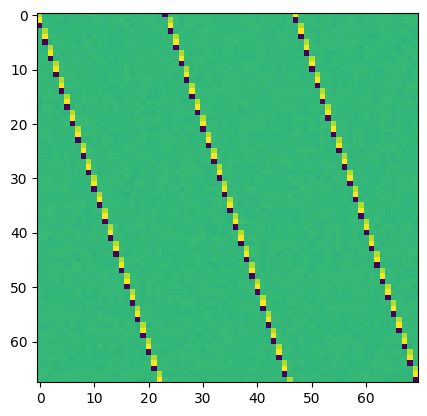

wandb: Network error (ConnectionError), entering retry loop.


In [43]:
for U_i in U.T:
    plt.imshow(U_i)
    plt.show()